# Context-Biasing for ASR models with CTC-based Word Spotter

This tutorial aims to show how to improve the recognition accuracy of specific words in NeMo framework
for CTC and Trasducer ASR models by using fast context-biasing method with CTC-based Word Spotter.

## Tutorial content:
* Intro in context-biasing problem
* Description of CTC-based Words Spotter (CTC-WS) approach
* Practical part 1 (base):
    * Download data set and ASR models
    * Build context-biasing list
    * Evaluate recognition results with and without context-biasing
* Practical part 2 (advance):
    * Visuilization of context-biasing graph
    * Running word spotter
    * Merge greedy decoding results with word spotter hypotheses
    * Results analysis
* Summary

## Context-biasing: intro

ASR models often struggle to recognize words that were absent or have few examples in the training data.
This problem is especially acute due to the emergence of new names and titles in a rapidly developing world.
The users need to be able to recognize these new words.
Context-biasing methods attempt to solve this problem by assuming that we have a list of words and phrases (context-biasing list) in advance
for which we want to improve recognition accuracy.

One of the directions of context-biasing methods is a `deep fusion` approach.
These methods require integration into the ASR model and its training process.
The main disadvantage of these methods is that they require a lot of computational resources and time to train the model.

Another direction is methods based on a `shallow fusion` approach. In this case, only the decoding process is modified.
During the beam-search decoding, the hypothesis is rescored depending on whether the current word is present in the context-biasing list or external language model.
The beam-search decoding may be computationally expensive, especially for the models with a large vocabulary and context-biasing list.
This problem is considerably worsened in the case of the Transducer (RNNT) model since beam-search decoding involves multiple Decoder (Prediction) and Joint networks calculations.
Moreover, the context-biasing recognition is limited by the initial predictions of the model. In the case of rare or new words,
the model may not have a hypothesis for the desired word from the context-biasing list whose probability we want to improve.

## CTC-based Word Spotter

<img width="500px" height="auto"
     src="cws.png"
     alt="CTC-WS"
     style="float: right; margin-left: 20px;">

This tutorial considers a fast context-biasing method using a CTC-based Word Spotter (CTC-WS) -- paper link.
The method involves decoding CTC log probabilities with a context graph built for words and phrases from the context-biasing list.
The spotted context-biasing candidates (with their scores and time intervals) are compared by scores with words from the greedy
CTC decoding results to improve recognition accuracy and pretend false accepts of context-biasing (Figure 1).

A Hybrid Transducer-CTC model [link] (a shared encoder trained together with CTC and Transducer output heads) 
allows the use of the CTC-WS method for the Transducer model.
Context-biasing candidates obtained by CTC-WS are also filtered by the scores with greedy CTC predictions and then merged with greedy Transducer results.

The CTC-WS method allows using pretrained NeMo models (`CTC` or `Hybrid Transducer-CTC`) for context-biasing recognition without model retraining.
The method shows inspired results for context-biasing with only a little additional work time and computational resources.

# Set up environment

In [ ]:
BRANCH = 'main'

"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""

import os
# either provide a path to local NeMo repository with NeMo already installed or git clone

# option #1: local path to NeMo repo with NeMo already installed
NEMO_DIR_PATH = os.path.dirname(os.path.dirname(os.path.abspath('')))
is_colab = False

# option #2: download NeMo repo
if 'google.colab' in str(get_ipython()) or not os.path.exists(os.path.join(NEMO_DIR_PATH, "nemo")):
    ## Install dependencies
    !apt-get install sox libsndfile1 ffmpeg

    !git clone -b $BRANCH https://github.com/NVIDIA/NeMo
    %cd NeMo
    !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
    NEMO_DIR_PATH = os.path.abspath('')
    is_colab = True

import sys
sys.path.insert(0, NEMO_DIR_PATH)

## Practical part 1 (base)
In this part, we will consider the base usage of the CTC-WS method for the pretrained NeMo model.

### Data preparation.
We will use a subset (10 files) of the GTC dataset. The dataset contains audio files with NVIDIA GTC talks. 
The primary dataset feature is the computer science and engineering domain, which has a large number of unique terms and product names (NVIDIA, GPU, GeForce, Ray Tracing, Omniverse, teraflops, etc.), which is ideal for the context-biasing task. All the text data is normalized and in lowercase.

In [25]:
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest

# data is already stored in nemo data manifest format
test_nemo_manifest = "/nemo_recipes/librispeech/data/gtc_test_set_3.0/gtc_jhh_manifest.json.filt_ml-35.json.filter_high_wer.tutorial"
test_data = read_manifest(test_nemo_manifest)

for idx, item in enumerate(test_data):
    print(f"[{idx}]: {item['text']}")

[0]: cunumeric accelerates numpy scaling from one gpu to multi gpu to multi node clusters to the largest supercomputers in the world
[1]: the nvidia quantum two the most advanced networking platform ever built
[2]: using nvidia modulus physics ml framework and omniverse we've created a digital twin platform with siemens
[3]: we have a brand new way to scale up dgx we can connect up to thirty two dgxs with nvlink today we are announcing the nvidia nvlink switch system
[4]: because dlss three generates a new frame without involving the game it benefits both gpu and cpu limited games
[5]: tsmc will be qualifying culitho for production starting in june
[6]: it was created by the researchers at l and m xlabs epic and nvidia it had two and a half million polygons or so two rays per pixel a couple of bounces per ray
[7]: first nvidia's tensorrt compiler has been integrated natively into tensorflow and pytorch
[8]: omniverse cloud replicator and farm containers are available on aws today
[9]: 

In [2]:
import librosa
import IPython.display as ipd

# load and listen to the audio file example
example_file = test_data[0]['audio_filepath']
audio, sample_rate = librosa.load(example_file)

file_id = 0
print(f"[TEXT {file_id}]: {test_data[file_id]['text']}\n")
ipd.Audio(example_file, rate=sample_rate)

[TEXT 0]: cunumeric accelerates numpy scaling from one gpu to multi gpu to multi node clusters to the largest supercomputers in the world



### Load ASR models

For testing the CTC-WS method, we will use the following NeMo models:
 - (CTC): [stt_en_fastconformer_ctc_large](https://huggingface.co/nvidia/stt_en_fastconformer_ctc_large) - a large fast-conformer model trained on English ASR data
 - (Hybrid Transducer-CTC): [stt_en_fastconformer_hybrid_large_streaming_multi](https://huggingface.co/nvidia/stt_en_fastconformer_hybrid_large_streaming_multi) - a large fast-conformer model trained jointly with CTC and Transducer heads on English ASR data. The last model is a streaming model, which means it can process audio in real time. It can cause a slight WER degradation in comparison with the first model.

In [3]:
from nemo.collections.asr.models import EncDecCTCModelBPE, EncDecHybridRNNTCTCBPEModel

# ctc model
ctc_model_name = "stt_en_fastconformer_ctc_large"
ctc_model = EncDecCTCModelBPE.from_pretrained(model_name=ctc_model_name)

# hybrid transducer-ctc model
hybrid_ctc_rnnt_model_name = "stt_en_fastconformer_hybrid_large_streaming_multi"
hybrid_ctc_rnnt_model = EncDecHybridRNNTCTCBPEModel.from_pretrained(model_name=hybrid_ctc_rnnt_model_name)

[NeMo I 2024-02-08 14:03:33 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo.
[NeMo I 2024-02-08 14:03:33 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo
[NeMo I 2024-02-08 14:03:33 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-02-08 14:03:34 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-02-08 14:03:35 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: fully_randomized
    bucketing_batch_size: null
    
[NeMo W 2024-02-08 14:03:35 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    num_workers: 8
    pin_m

[NeMo I 2024-02-08 14:03:35 features:289] PADDING: 0
[NeMo I 2024-02-08 14:03:36 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo.
[NeMo I 2024-02-08 14:03:36 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo.
[NeMo I 2024-02-08 14:03:36 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo
[NeMo I 2024-02-08 14:03:36 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-02-08 14:03:37 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-02-08 14:03:38 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /raid/local//bucket1/tarred_audio_manifest.json
    - - /raid/local//bucket2/tarred_audio_manifest.json
    - - /raid/local//bucket3/tarred_audio_manifest.json
    - - /raid/local//bucket4/tarred_audio_manifest.json
    - - /raid/local//bucket5/tarred_audio_manifest.json
    - - /raid/local//bucket6/tarred_audio_manifest.json
    - - /raid/local//bucket7/tarred_audio_manifest.json
    - - /raid/local//bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 25
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths:
    - - /data2/nemo_asr/nemo_asr_set_3.0//bucket1/audi

[NeMo I 2024-02-08 14:03:38 features:289] PADDING: 0


[NeMo W 2024-02-08 14:03:39 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2024-02-08 14:03:39 rnnt_models:222] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.005, 'clamp': -1.0}
[NeMo I 2024-02-08 14:03:40 save_restore_connector:263] Model EncDecHybridRNNTCTCBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo.


### Transcribe 
Let's transcribe test data and analyze regontion accuracy of specific words 

In [4]:
test_audio_files = [item['audio_filepath'] for item in test_data]
recog_results = ctc_model.transcribe(test_audio_files)

Transcribing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


### Compute per-word recognition statisctic

In [5]:
import texterrors

word_dict = {} # {word: [num_of_occurance, num_of_correct_recognition]}
eps = "<eps>"
ref_text = [item['text'] for item in test_data]

for idx, ref in enumerate(ref_text):
    ref = ref.split()
    hyp = recog_results[idx].split()
    texterrors_ali = texterrors.align_texts(ref, hyp, False)
    ali = []
    for i in range(len(texterrors_ali[0])):
        ali.append((texterrors_ali[0][i], texterrors_ali[1][i]))

    for pair in ali:
        word_ref, word_hyp = pair
        if word_ref == eps:
            continue
        if word_ref in word_dict:
            word_dict[word_ref][0] += 1
        else:
            word_dict[word_ref] = [1, 0]
        if word_ref == word_hyp:
            word_dict[word_ref][1] += 1

word_candidats = {}

for word in word_dict:
    gt = word_dict[word][0]
    tp = word_dict[word][1]
    if tp/gt < 1.0:
        word_candidats[word] = [gt, round(tp/gt, 2)]
        
# print obtained per-word statistic
word_candidats_sorted = sorted(word_candidats.items(), key=lambda x:x[1][0], reverse=True)
max_word_len = max([len(x[0]) for x in word_candidats_sorted])
for item in word_candidats_sorted:
    print(f"{item[0]:<{max_word_len}} {item[1][0]}/{item[1][1]}")

gpu        5/0.0
nvidia     4/0.25
we         4/0.75
nvlink     3/0.0
are        3/0.67
omniverse  2/0.0
today      2/0.0
cunumeric  1/0.0
numpy      1/0.0
ml         1/0.0
dgx        1/0.0
dgxs       1/0.0
dlss       1/0.0
cpu        1/0.0
tsmc       1/0.0
culitho    1/0.0
l          1/0.0
xlabs      1/0.0
nvidia's   1/0.0
tensorrt   1/0.0
tensorflow 1/0.0
pytorch    1/0.0
aws        1/0.0
inference  1/0.0
chatgpt    1/0.0
pcie       1/0.0
gb         1/0.0


## Create a context-biasing list

Now, we need to select the words, recognition of wich we want to improve by CTC-WS context-biasing.
Usually, we select only not trivial words with the lowest recognition accuracy.
Such words should have a character length >= 3 because short words in a context-biasing list may produce high false-positive recognition.
In this toy example, we will select all the words that look like names with a recognition accuracy of less than 1.0.

The structure of the context-biasing file is:

WORD1_TRANSCRIPTION1  
WORD2_TRANSCRIPTION1   
...

TRANSCRIPTION here is a word spelling. We need this structure to add alternative transcriptions (spellings) for one specific word. We will cover such a case further.

In [6]:
cb_words = ["gpu", "nvidia", "nvidia's", "nvlink", "omniverse", "cunumeric", "numpy", "dgx", "dgxs", "dlss",
            "cpu", "tsmc", "culitho", "xlabs", "tensorrt", "tensorflow", "pytorch", "aws", "chatgpt", "pcie"]

# write context-biasing file 
cb_list_file = "context_biasing_list.txt"
with open(cb_list_file, "w", encoding="utf-8") as fn:
    for word in cb_words:
        fn.write(f"{word}_{word}\n")

In [7]:
!cat {cb_list_file}

gpu_gpu
nvidia_nvidia
nvidia's_nvidia's
nvlink_nvlink
omniverse_omniverse
cunumeric_cunumeric
numpy_numpy
dgx_dgx
dgxs_dgxs
dlss_dlss
cpu_cpu
tsmc_tsmc
culitho_culitho
xlabs_xlabs
tensorrt_tensorrt
tensorflow_tensorflow
pytorch_pytorch
aws_aws
chatgpt_chatgpt
pcie_pcie


## Run context-biasing evaluation

The main script for CTC-WS context-biasing in NeMo is:\
`{NeMo_root}/scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py`

Context-biasing is managed by `apply_context_biasing` parameter [true or false].  
Other important context-biasing parameters are:
- `beam_threshold` - threshold for CTC-WS beam pruning
- `context_score` - per token weight for context biasing
- `ctc_ali_token_weight` - per token weight for CTC alignment (prevents false acceptances of context-biasing words) 

All the context-biasing parameters are selected according to the default values in the biasing script.  
You can tune them according to your data and ASR model (list all the values in the [] separated by commas)  
for example: `beam_threshold=[7.0,8.0,9.0]`, `context_score=[3.0,4.0,5.0]`, `ctc_ali_token_weight=[0.5,0.6,0.7]`.  
The script will run the recognition with all the combinations of the parameters and will select the best one based on WER value.

In [8]:
# create directory with experimental results
import os

exp_dir = "exp"
if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)
else:
    print(f"Directory '{exp_dir}' already exists")

Directory 'exp' already exists


In [9]:
# ctc model (no context-biasing)

!python ../../scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py \
            nemo_model_file={ctc_model_name} \
            input_manifest={test_nemo_manifest} \
            preds_output_folder={exp_dir} \
            decoder_type="ctc" \
            acoustic_batch_size=64 \
            apply_context_biasing=false \
            context_file={cb_list_file} \
            beam_threshold=[7.0] \
            context_score=[3.0] \
            ctc_ali_token_weight=[0.5]

[NeMo W 2024-02-08 13:42:14 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2024-02-08 13:42:14 eval_greedy_decoding_with_context_biasing:335] nemo_model_file does not end with .nemo, therefore trying to load a pretrained model with this name.
[NeMo I 2024-02-08 13:42:14 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo.
[NeMo I 2024-02-08 13:42:14 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo
[NeMo I 2024-02-08 13:42:14 common:815] Instantiating model from pre-trained ch

The results must be:

`Precision`: 1.0000 (1/1) fp:0 (fp - false positive recognition)  
`Recall`:    0.0333 (1/30)  
`Fscore`:    0.0645  
`Greedy WER/CER` = 35.68%/8.16%

The model could recognize 1 out of 29 words from the context-biasing list.
Let's enable context-biasing during decoding:

In [10]:
# ctc model (with context biasing)
!python ../../scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py \
            nemo_model_file={ctc_model_name} \
            input_manifest={test_nemo_manifest} \
            preds_output_folder={exp_dir} \
            decoder_type="ctc" \
            acoustic_batch_size=64 \
            apply_context_biasing=true \
            context_file={cb_list_file} \
            beam_threshold=[7.0] \
            context_score=[3.0] \
            ctc_ali_token_weight=[0.5]

[NeMo W 2024-02-08 13:43:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2024-02-08 13:43:36 eval_greedy_decoding_with_context_biasing:335] nemo_model_file does not end with .nemo, therefore trying to load a pretrained model with this name.
[NeMo I 2024-02-08 13:43:36 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo.
[NeMo I 2024-02-08 13:43:36 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo
[NeMo I 2024-02-08 13:43:36 common:815] Instantiating model from pre-trained ch

Now, recognition results are much better:

`Precision`: 1.0000 (21/21) fp:0  
`Recall`:    0.7000 (20/29)  
`Fscore`:    0.8235  
`Greedy WER/CER` = 17.09%/4.43%

But we are still able to recognize only 21 out of 30 specific words.\
You can see that unrecognized words are mostly abbreviations (`dgxs`, `dlss`, `gpu`, `aws`, etc.) or complicated words (`culitho`).\
The ASR models tends to recognize such words as a sequence of characters (`"aws" -> "a w s"`) or subwords (`"culitho" -> "cu litho"`).\
We can try to improve the recognition of such words by adding alternative transcriptions to the context-biasing list.

### Alternative transcriptions

wordninja is used to split complicated words into simple words

In [11]:
!pip install wordninja

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541552 sha256=b10ce6988ea122d87b2de83665c2644cb4a83d6685d3c87c6672709c1d3488d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-fgbcu92t/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import wordninja

cb_list_file_modified = cb_list_file + ".abbr_and_ninja"

with open(cb_list_file, "r", encoding="utf-8") as fn1, \
    open(cb_list_file_modified, "w", encoding="utf-8") as fn2:

    for line in fn1:
        word = line.strip().split("_")[0]
        new_line = f"{word}_{word}"
        # split all the short words into characters
        if len(word) <= 4 and len(word.split()) == 1:
            abbr = ' '.join(list(word))
            new_line += f"_{abbr}"
        # split the long words into the simple words (not for phrases)
        new_segmentation = wordninja.split(word)
        if word != new_segmentation[0]:
            new_segmentation = ' '.join(new_segmentation)
            new_line += f"_{new_segmentation}"
        fn2.write(f"{new_line}\n")

In [9]:
!cat {cb_list_file_modified}

gpu_gpu_g p u
nvidia_nvidia
nvidia's_nvidia's
nvlink_nvlink_nv link
omniverse_omniverse
cunumeric_cunumeric_cu numeric
numpy_numpy_num py
dgx_dgx_d g x_d gx
dgxs_dgxs_d g x s_d gx s
dlss_dlss_d l s s_dl s s
cpu_cpu_c p u
tsmc_tsmc_t s m c_t smc
culitho_culitho_cu litho
xlabs_xlabs_x labs
tensorrt_tensorrt_tensor rt
tensorflow_tensorflow_tensor flow
pytorch_pytorch_py torch
aws_aws_a w s_aw s
chatgpt_chatgpt_chat gp t
pcie_pcie_p c i e


Run context-biasing with modified context-biasing list:

In [14]:
# ctc models (with context biasing and modified cb list)
!python ../../scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py \
            nemo_model_file={ctc_model_name} \
            input_manifest={test_nemo_manifest} \
            preds_output_folder={exp_dir} \
            decoder_type="ctc" \
            acoustic_batch_size=64 \
            apply_context_biasing=true \
            context_file={cb_list_file_modified} \
            beam_threshold=[7.0] \
            context_score=[3.0] \
            ctc_ali_token_weight=[0.5]

[NeMo W 2024-02-08 13:43:58 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2024-02-08 13:43:58 eval_greedy_decoding_with_context_biasing:335] nemo_model_file does not end with .nemo, therefore trying to load a pretrained model with this name.
[NeMo I 2024-02-08 13:43:58 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo.
[NeMo I 2024-02-08 13:43:58 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_ctc_large/00a071a9dac048acc3aeea942b0bfa40/stt_en_fastconformer_ctc_large.nemo
[NeMo I 2024-02-08 13:43:58 common:815] Instantiating model from pre-trained ch

Now, the recognition results are:

`Precision`: 1.0000 (28/28) fp:1  
`Recall`:    0.9333 (28/30)  
`Fscore`:    0.9655  
`Greedy WER/CER` = 7.04%/2.93%

As you can see, adding alternative transcriptions to the cb_list file improved the recognition accuracy of the context-biasing words. However, we still miss 2 words.

In some cases, you can add alternative transcription manually based on recognition errors of your ASR model for the specific words (for example, `"nvidia" -> "n video"`) 

### Hybrid Transducer-CTC model
CTC-WS context-biasing for Transducer models is supported only for Hybrid Transducer-CTC model.  
To use Transducer head of the Hybrid Transducer-CTC model, we need to set `decoder_type="rnnt"`.  
Other parameters are the same as for the CTC model because the context-biasing is applied only to the CTC part of the model. Spotted context-biasing words will be merged with greedy decoding results of the Transducer head.

In [15]:
# Transducer model (no context-biasing)
!python ../../scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py \
            nemo_model_file={hybrid_ctc_rnnt_model_name} \
            input_manifest={test_nemo_manifest} \
            preds_output_folder={exp_dir} \
            decoder_type="ctc" \
            acoustic_batch_size=64 \
            apply_context_biasing=false \
            context_file={cb_list_file_modified} \
            beam_threshold=[7.0] \
            context_score=[3.0] \
            ctc_ali_token_weight=[0.5]

[NeMo W 2024-02-08 13:44:14 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2024-02-08 13:44:14 eval_greedy_decoding_with_context_biasing:335] nemo_model_file does not end with .nemo, therefore trying to load a pretrained model with this name.
[NeMo I 2024-02-08 13:44:14 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo.
[NeMo I 2024-02-08 13:44:14 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo
[Ne

In [16]:
# Transducer model (with context-biasing)
!python ../../scripts/asr_context_biasing/eval_greedy_decoding_with_context_biasing.py \
            nemo_model_file={hybrid_ctc_rnnt_model_name} \
            input_manifest={test_nemo_manifest} \
            preds_output_folder={exp_dir} \
            decoder_type="ctc" \
            acoustic_batch_size=64 \
            apply_context_biasing=true \
            context_file={cb_list_file_modified} \
            beam_threshold=[7.0] \
            context_score=[3.0] \
            ctc_ali_token_weight=[0.5]

[NeMo W 2024-02-08 13:44:33 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2024-02-08 13:44:33 eval_greedy_decoding_with_context_biasing:335] nemo_model_file does not end with .nemo, therefore trying to load a pretrained model with this name.
[NeMo I 2024-02-08 13:44:33 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo.
[NeMo I 2024-02-08 13:44:33 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_en_fastconformer_hybrid_large_streaming_multi/a22a1091ef0b90f40b4e99859c44b15e/stt_en_fastconformer_hybrid_large_streaming_multi.nemo
[Ne

CTC-WS context-biasing works for Transducer model as well as for CTC (`F-score improvenment: 0.1250 -> 0.9286`). Differences in the nature of offline and online models may cause differences in results (usually, online models have lower accuracy than online ones). 

## Practical part 2 (advanced)
In this section, we will consider the context-biasing process more deeply:
- Visualization of the context-biasing graph
- Running CTC-WS with the context-biasing graph
- Merge the obtained spotted words with greedy decoding results
- Analysis of the results

### Build a context graph (for visualization only)
The context graph consists of a composition of a prefix tree (Trie) with the CTC transition topology for words and phrases from the context-biasing list. We use a BPE tokenizer from the target ASR model for word segmentation.

In [30]:
try:
    import graphviz

    GRAPHVIZ_AVAILABLE = True
except (ImportError, ModuleNotFoundError):
    GRAPHVIZ_AVAILABLE = False

if not GRAPHVIZ_AVAILABLE:
    # install graphviz from source
    !../../scripts/installers/install_graphviz.sh

In [31]:
from nemo.collections.asr.parts import context_biasing

# get bpe tokenization
cb_words_small = ["nvidia", "gpu", "nvlink", "numpy"]
context_transcripts = []
for word in cb_words_small:
    # use text_to_tokens method for viasualization only
    word_tokenization = hybrid_ctc_rnnt_model.tokenizer.text_to_tokens(word)
    context_transcripts.append([word, [word_tokenization]])

# build context graph
context_graph = context_biasing.ContextGraphCTC(blank_id="<b>")
context_graph.add_to_graph(context_transcripts)

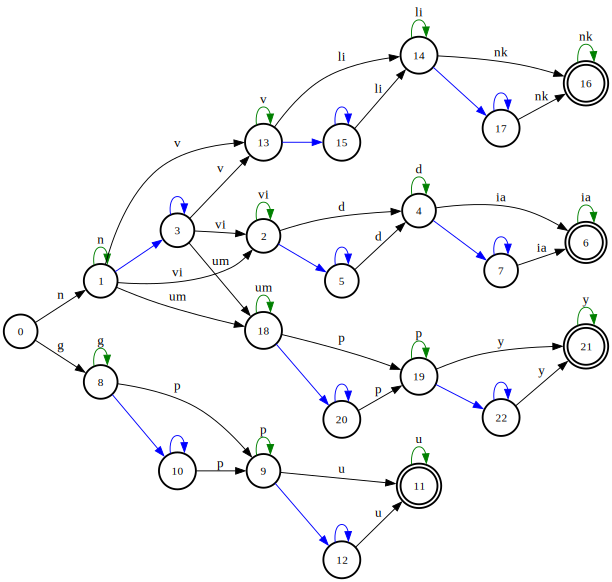

In [32]:
context_graph.draw()

bold arcs - ordinal non-blank transitions  
green arcs - non-blank self-loops  
blue arcs - blank transitions  


### Build a real context graph (for decoding)

In [19]:
# get bpe tokenization
context_transcripts = []
for word in cb_words:
    word_tokenization = [hybrid_ctc_rnnt_model.tokenizer.text_to_ids(x) for x in word]
    context_transcripts.append([word, word_tokenization])

# build context graph
context_graph = context_biasing.ContextGraphCTC(blank_id=hybrid_ctc_rnnt_model.decoder.blank_idx)
context_graph.add_to_graph(context_transcripts)

### Run CTC-based Word Spotter

The CTC-WS task is to search for words by decoding CTC log probabilities using the context graph. As a result, we get a list of detected words with exact start/end frames in the audio file and overall scores. The relatively small size of the context graph and methods for hypotheses pruning allow this algorithm to work very quickly.

In [21]:
import torch
from tqdm.notebook import tqdm

# get ctc logprobs
audio_file_paths = [item['audio_filepath'] for item in test_data]

with torch.no_grad():
    ctc_model.eval()
    ctc_model.encoder.freeze()
    device = next(ctc_model.parameters()).device
    hyp_results = ctc_model.transcribe(audio_file_paths, batch_size=10, return_hypotheses=True)
    ctc_logprobs = [hyp.alignments.cpu().numpy() for hyp in hyp_results]
    blank_idx = ctc_model.decoding.blank_id
    
# run ctc-based word spotter
ws_results = {}
for idx, logits in tqdm(
    enumerate(ctc_logprobs), desc=f"Eval CTC-based Word Spotter...", total=len(ctc_logprobs)
):
    ws_results[audio_file_paths[idx]] = context_biasing.run_word_spotter(
        logits,
        context_graph,
        ctc_model,
        blank_idx=blank_idx,
        beam_threshold=7.0,
        cb_weight=3.0,
        ctc_ali_token_weight=0.5,
    )

Transcribing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Eval CTC-based Word Spotter...:   0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# print CTC-WS hypotheses for the first audio file
ws_results[audio_file_paths[0]]

[WSHyp(word='nvlink', score=2.472485065460205, start_frame=6, end_frame=6),
 WSHyp(word='nvidia', score=2.8890712559223175, start_frame=11, end_frame=11),
 WSHyp(word='nvidia', score=2.9991016847779974, start_frame=17, end_frame=17),
 WSHyp(word='nvidia', score=2.962240591645241, start_frame=25, end_frame=25),
 WSHyp(word="nvidia's", score=2.9999133386008907, start_frame=34, end_frame=34),
 WSHyp(word='gpu', score=2.996793291065842, start_frame=48, end_frame=48),
 WSHyp(word='gpu', score=2.2584730982780457, start_frame=51, end_frame=51),
 WSHyp(word='gpu', score=2.8708082139492035, start_frame=69, end_frame=69),
 WSHyp(word='gpu', score=2.1114726066589355, start_frame=73, end_frame=73),
 WSHyp(word='cunumeric', score=2.9999777081120556, start_frame=94, end_frame=94)]

### Merge CTC-WS words with greedy CTC decoding results

Use `print_stats=True` to get more information about spotted words and greedy CTC word alignment.

In [22]:
import numpy as np

target_transcripts = [item['text'] for item in test_data]

# merge spotted words with greedy results
for idx, logprobs in enumerate(ctc_logprobs):
    greedy_predicts = np.argmax(logprobs, axis=1)
    if ws_results[audio_file_paths[idx]]:
        # make new text by mearging alignment with ctc-ws predictions:
        print("\n" + "********" * 10)
        print(f"File name: {audio_file_paths[idx]}")
        pred_text, raw_text = context_biasing.merge_alignment_with_ws_hyps(
            greedy_predicts,
            ctc_model,
            ws_results[audio_file_paths[idx]],
            decoder_type="ctc",
            blank_idx=blank_idx,
            print_stats=True,
        )
        print(f"[raw text]: {raw_text}")
        print(f"[hyp text]: {pred_text}")
        print(f"[ref text]: {target_transcripts[idx]}")
    else:
        pred_text = asr_model.wer.decoding.ctc_decoder_predictions_tensor(greedy_predicts)[0][0]


********************************************************************************
File name: /mnt/ssd/data/gtc_test_set_3.0/raw_data/jhh_full_audio/converted/segmented_data/clips/8000_GTC_November_2021_Keynote_with_NVIDIA_CEO_Jensen_Huang.16khz.mono.trim_0063.wav
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:105] Word alignment: [('kon', 6, 9), ('numeric', 11, 15), ('accelerates', 17, 24), ('numpi', 25, 30), ('scaling', 34, 38), ('it', 40, 40), ('from', 42, 42), ('one', 45, 45), ('g', 48, 48), ('p', 51, 51), ('to', 60, 60), ('multi', 63, 66), ('g', 69, 69), ('p', 73, 73), ('to', 79, 79), ('multi', 82, 85), ('node', 88, 91), ('clusters', 94, 100), ('to', 104, 104), ('the', 107, 107), ('largest', 109, 113), ('supercomputers', 115, 125), ('in', 127, 127), ('the', 128, 128), ('world', 130, 130)]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvlink [6, 6]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia [11, 11]
[NeMo I 2024-02-08 14:15:

[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvlink [8, 9]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia's [10, 10]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia's [13, 13]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia [24, 24]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [73, 73]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [76, 76]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [79, 79]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: cunumeric [90, 90]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [94, 94]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [96, 96]
[raw text]: because the s s three generates a new frame without involving the game it benefits both g p u and c p u limited games
[hyp text]: because the nvlink

[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [32, 32]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [35, 35]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia [67, 67]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [80, 80]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [98, 98]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: culitho [116, 116]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [148, 148]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: omniverse [156, 156]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: nvidia [158, 158]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: culitho [177, 177]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted word: gpu [204, 204]
[NeMo I 2024-02-08 14:15:39 context_biasing_utils:138] Spotted wor

In these logs, you can find detailed context-biasing statistics about each audio file:
- Audio file name
- Greedy word alignment
- List of spotted words
- Text results:
    - Greedy decoding (raw text)
    - After context-biasing (hyp text)
    - Ground truth transcription (ref text)
    
These statistics can be helpful in case of problems with context-biasing word recognition. For example, Transducer models sometimes recognize tokens 1-2 frames earlier than CTC models. To solve this problem, you can shift the start frame of the detected word left.

## Summary

This tutorial demonstrates how to use the CTC-WS context-biasing technique to improve the recognition of specific words in the audio data in the case of CTC and Transducer ASR models. The tutorial includes the methodology for creating the context-biasing list, improving recognition accuracy of abbreviations and complex words, visualization of the context-biasing process, and results analysis.
